### Dataset Description 

GBTC is a Bitcoin Investment Trust traded on exchange. It holds physical bitcoins and derive its value from them. Because it's traded on a regulated exchange, it is a lot more liquid than bitcoin itself, which trades on unregulated bitcoin marketplaces and has fraud risk and risk of being stolen. Hence, GBTC is traded at a premium to its underlying. The goal of this study is to seek out what drives the premium and whether there are signals that potentially lead to a profitable strategy

GBTC.csv contains GBTC's price and volume on a 15-minute interval. 

XBT.csv contains only the price of XBT with the same frequency. Volume is absent because bitcoins are traded across numerous exchanges and there's no such aggregated volume figure. 

Both datasets span a time frame from 2017-6-21 to 2017-12-22, 15:45 end time.  

### Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
% matplotlib inline 

In [2]:
df_GBTC = pd.read_csv('GBTC.csv')
df_XBT = pd.read_csv('XBT.csv')

In [3]:
df_GBTC.describe();
df_GBTC.head()

,Date_time,Volume,Price
0,6/21/17 9:30,3584,460.00
1,6/21/17 9:45,2946,454.90
2,6/21/17 10:00,224,456.00
3,6/21/17 10:15,697,452.25
4,6/21/17 10:30,550,440.00


In [4]:
df_XBT.describe();
df_XBT.head()

,Date_time,Price
0,6/21/17 0:00,2745.7000
1,6/21/17 0:15,2757.8179
2,6/21/17 0:30,2755.8149
3,6/21/17 0:45,2779.7600
4,6/21/17 1:00,2758.3452


In [5]:
# now you will notice Date_time is stored as a string type, which we will have to change into timestamp 
type(df_GBTC.Date_time[0])

str

Convert Date_time into a timestamp series

In [6]:
df_GBTC.Date_time = pd.to_datetime(df_GBTC.Date_time) 
df_XBT.Date_time = pd.to_datetime(df_XBT.Date_time)

### Now we get a quick peek at data
Note the price levels are not comparable, as XBT is almost 10 times as high, so we will need to normalize them for comparison

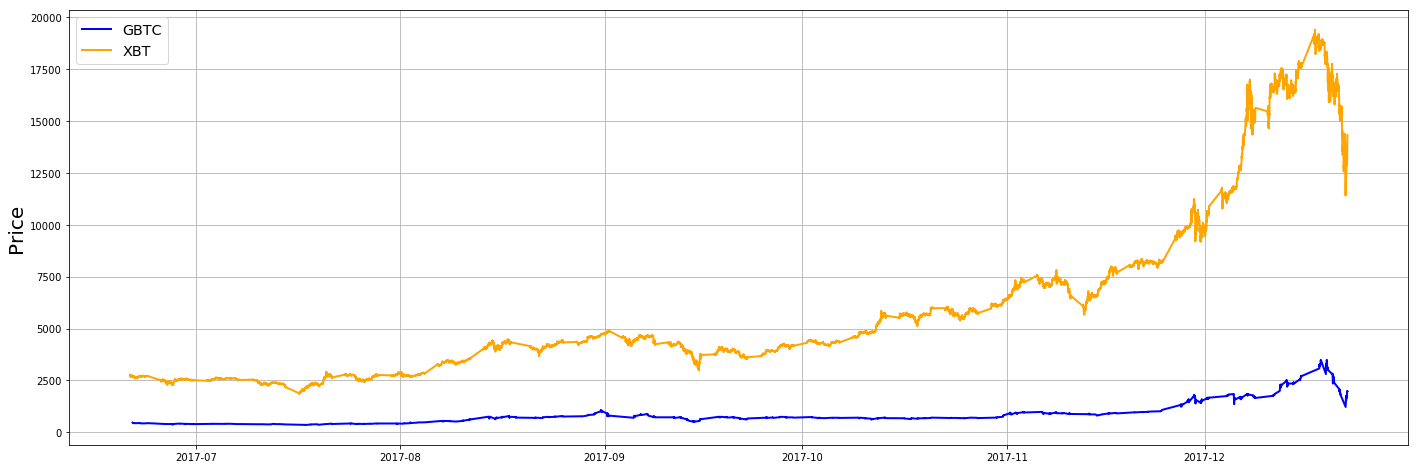

In [7]:
fig, ax0 = plt.subplots(figsize = (24,8))

ax0.plot(df_GBTC.Date_time.values, df_GBTC.Price, label = 'GBTC', color = 'blue', lw =2)
ax0.plot(df_XBT.Date_time.values, df_XBT.Price, label = 'XBT', color = 'orange', lw =2)
ax0.set_ylabel('Price', fontsize=20, color="black")
ax0.legend(loc=2, fontsize = 'x-large')
ax0.grid(True)

Putting together the volume and price of GBTC requires a bit formatting on the datetime distribution. 

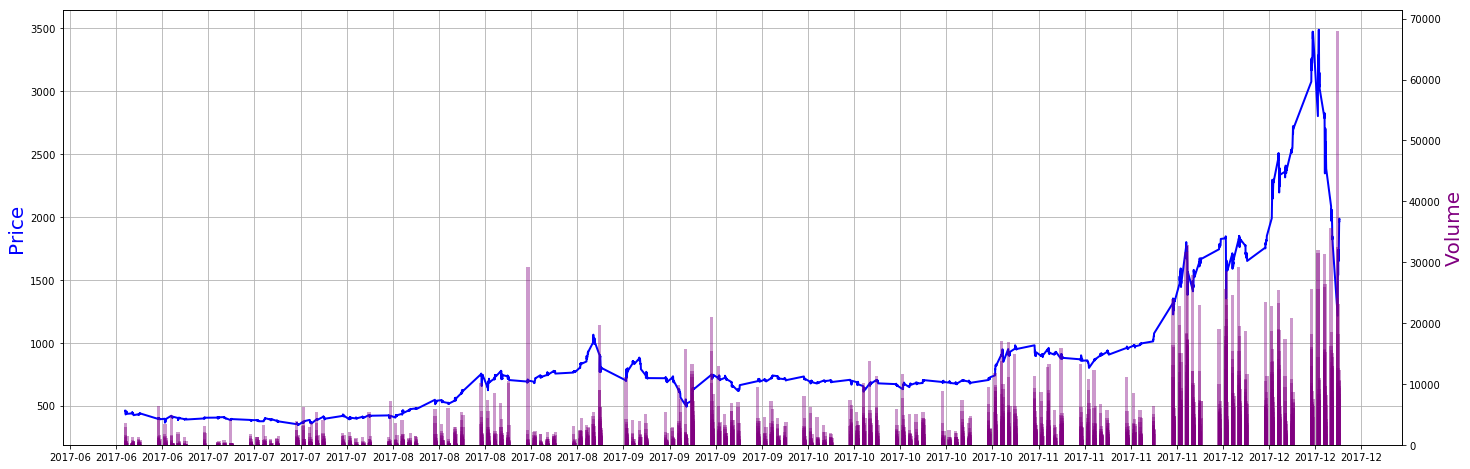

In [8]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize = (24,8))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) ## format the display form
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())  ## format the interval distance 

ax1.plot(df_GBTC.Date_time.values, df_GBTC.Price,  color = 'blue', lw =2)
ax1.set_ylabel('Price', fontsize=20, color="blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(df_GBTC.Date_time.values, df_GBTC.Volume, width=0.5, align='center', color = 'purple', alpha = 0.4)
ax2.set_ylabel('Volume', fontsize=20, color="purple")

### Data Preprocessing

First, I remove the dates in XBT that are non-trading days because GBTC only trades on regular trading days.

Then I adjust XBT's price by a factor such that it's commensurate with GBTC's NAV value. 

I then split XBT dataset into intrady (9:30-15:45), when GBTC trades, and overnight (16:00-9:15) when market is closed.


In [9]:
# Remove XBT non-trading period data
concurrent_dates = df_GBTC.Date_time.dt.date.unique()
df_XBT = df_XBT[df_XBT.Date_time.dt.date.isin(concurrent_dates)]   

In [10]:
# Use 12/21 16:00 (market close time) as the reference point for NAV calculation

NAV_12_21_close = 1482.64 # this is the NAV as of 12-21 4pm
XBT_12_21_close = df_XBT.Price[df_XBT.Date_time == pd.to_datetime('2017-12-21 16:00:00')].values
Adjust_factor = NAV_12_21_close/XBT_12_21_close
df_XBT['NAV_Adj_XBT'] = df_XBT.Price*Adjust_factor

In [11]:
# Double check if the values are correctly converted 
df_XBT.NAV_Adj_XBT[df_XBT.Date_time == pd.to_datetime('2017-12-21 16:00:00')] == NAV_12_21_close

12833    True
Name: NAV_Adj_XBT, dtype: bool

In [12]:
# Now, the last step is to split df_XBT into overnight and intraday, and merge the intraday set with the GBTC dataset

tmp1 = df_XBT[df_XBT.Date_time.dt.strftime('%H:%M:%S').between('00:00:00','09:15:00')]
tmp2 = df_XBT[df_XBT.Date_time.dt.strftime('%H:%M:%S').between('16:00:00','23:45:00')]
df_XBT_overnight = pd.concat([tmp1, tmp2], axis=0)
df_XBT_overnight.sort_values(by='Date_time',ascending = True, inplace=True)
df_XBT_overnight.rename(index = str, columns={'Price':'Price_XBT_unadj', 'NAV_Adj_XBT':'Adj_NAV'})

df_XBT_overnight.head() # make sure the truncation was done correctly 

,Date_time,Price,NAV_Adj_XBT
0,2017-06-21 00:00:00,2745.7000,270.283269
1,2017-06-21 00:15:00,2757.8179,271.476140
2,2017-06-21 00:30:00,2755.8149,271.278967
3,2017-06-21 00:45:00,2779.7600,273.636093
4,2017-06-21 01:00:00,2758.3452,271.528047


#### Additional Variables: 

1. NAV_chg_pct, = change in NAV 
2. Spread = (GBTC Price - NAV)
3. Spread_pct, = (GBTC Price - NAV)/NAV
4. Spread_chg_pct, = change in Spread_pct 

In [13]:
df_merged = pd.merge(df_GBTC, df_XBT, how= 'inner', on = 'Date_time')
df_merged.rename(index = str, columns={'Price_x': 'Price_GBTC', 'Price_y': 'Price_XBT_unadj', 'NAV_Adj_XBT':'Adj_NAV'}, inplace=True)

df_merged['Spread'] = df_merged.Price_GBTC - df_merged.Adj_NAV
df_merged['Spread_pct'] = df_merged.Spread / df_merged.Adj_NAV
df_merged['NAV_chg_pct'] = df_merged.Adj_NAV.diff()/df_merged.Adj_NAV
df_merged['Spread_chg_pct'] = df_merged.Spread_pct.diff()/df_merged.Spread_pct
df_merged['log_Volume_chg'] = np.log10(df_merged.Volume).diff()
df_merged.dropna(axis=0, inplace=True)  # drop the first line as it's a NaN from diff() calculation

df_merged.head(5)

,Date_time,Volume,Price_GBTC,Price_XBT_unadj,Adj_NAV,Spread,Spread_pct,NAV_chg_pct,Spread_chg_pct,log_Volume_chg
1,2017-06-21 09:45:00,2946,454.90,2710.0684,266.775739,188.124261,0.705178,-0.007495,-0.008920,-0.085135
2,2017-06-21 10:00:00,224,456.00,2720.0269,267.756041,188.243959,0.703043,0.003661,-0.003036,-1.118985
3,2017-06-21 10:15:00,697,452.25,2701.2800,265.910620,186.339380,0.700759,-0.006940,-0.003258,0.492985
4,2017-06-21 10:30:00,550,440.00,2680.5066,263.865712,176.134288,0.667515,-0.007750,-0.049804,-0.102870
5,2017-06-21 10:45:00,1599,441.75,2681.9751,264.010270,177.739730,0.673230,0.000548,0.008490,0.463486


#### Additional Variables (cont'd):

 5. Month, created to see period-by-period trend
 6. Session, divided intraday trading into three sub-periods, Early open (9:30-11:00), Closing (15:00-16:00), and Midday, the remainder

In [14]:
## create session() function to divide time periods into open, midday, close buckets

def session(t):
    if  time(9,15) < t < time(11,0):
        return 'Early open'
    elif time(14,45) < t < time(16,0):
        return 'Closing'
    else:
        return 'Midday'

In [15]:
# Next, I added several characteristic variables such as month and time range, to explore how spread changes 
# over months and in certain time periods of the day

df_merged['Month'] = df_merged.Date_time.dt.month
df_merged['Session'] = df_merged.Date_time.dt.time.apply(lambda x: session(x))
df_merged.head()

,Date_time,Volume,Price_GBTC,Price_XBT_unadj,Adj_NAV,Spread,Spread_pct,NAV_chg_pct,Spread_chg_pct,log_Volume_chg,Month,Session
1,2017-06-21 09:45:00,2946,454.90,2710.0684,266.775739,188.124261,0.705178,-0.007495,-0.008920,-0.085135,6,Early open
2,2017-06-21 10:00:00,224,456.00,2720.0269,267.756041,188.243959,0.703043,0.003661,-0.003036,-1.118985,6,Early open
3,2017-06-21 10:15:00,697,452.25,2701.2800,265.910620,186.339380,0.700759,-0.006940,-0.003258,0.492985,6,Early open
4,2017-06-21 10:30:00,550,440.00,2680.5066,263.865712,176.134288,0.667515,-0.007750,-0.049804,-0.102870,6,Early open
5,2017-06-21 10:45:00,1599,441.75,2681.9751,264.010270,177.739730,0.673230,0.000548,0.008490,0.463486,6,Early open


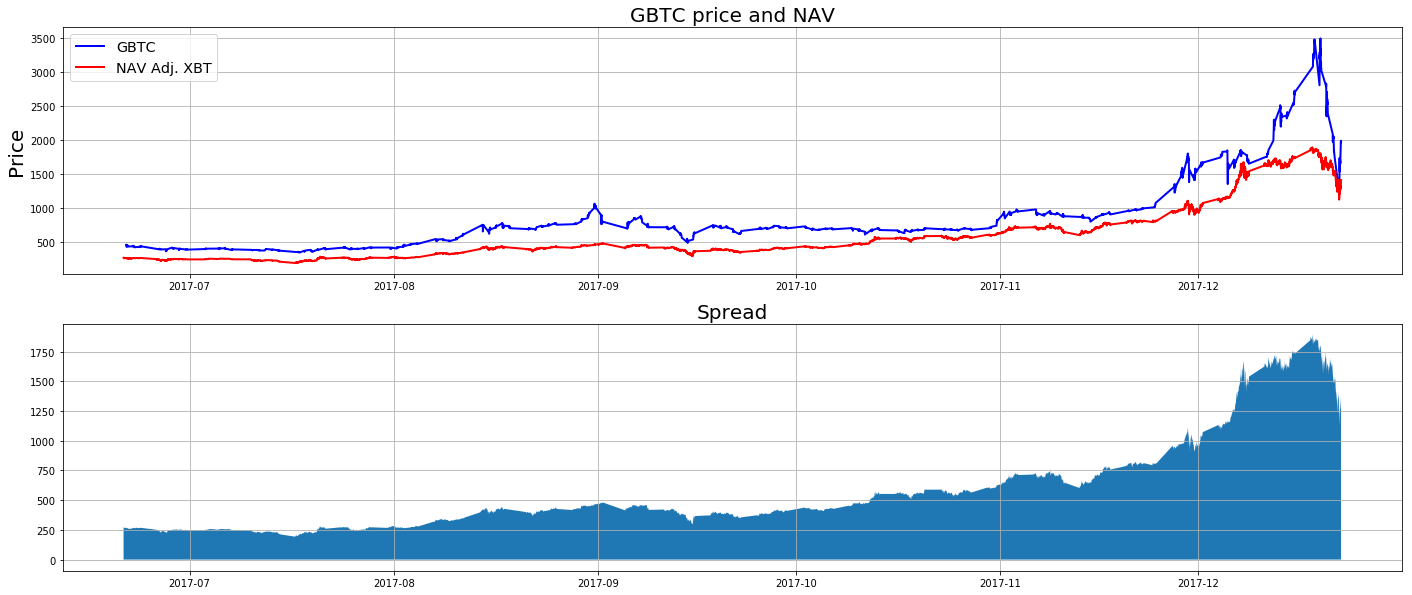

In [22]:
fig, ax = plt.subplots(2, 1, figsize = (24,10))

ax[0].plot(df_GBTC.Date_time.values, df_GBTC.Price, label = 'GBTC', color = 'blue', lw =2)
ax[0].plot(df_XBT.Date_time.values, df_XBT.NAV_Adj_XBT, label = 'NAV Adj. XBT', color = 'red', lw =2)
ax[0].set_ylabel('Price', fontsize=20, color="black")
ax[0].legend(loc=2, fontsize = 'x-large')
ax[0].set_title('GBTC price and NAV', loc='center', fontsize = 20)
ax[0].grid(True)

ax[1].stackplot(df_XBT.Date_time.values, df_XBT.NAV_Adj_XBT)
ax[1].set_title('Spread', loc='center', fontsize = 20)
ax[1].grid(True)

### Data Exploratory Analysis
I will focus on two subjects: Spread% and Change in Spread%. 

> **Spread%**
  
 > - Distribution by Month and by Session 
  
> **Spread_chg_pct**
  
 > - Distribution by Month and by Session 
 
 > - Any correlation 

In [24]:
import seaborn as sns

**Spread% distribution:**

The overall distribution looks multi-modal (multiple peaks). As I broke it down into individual months, it looks even messier. No conformation at all! 

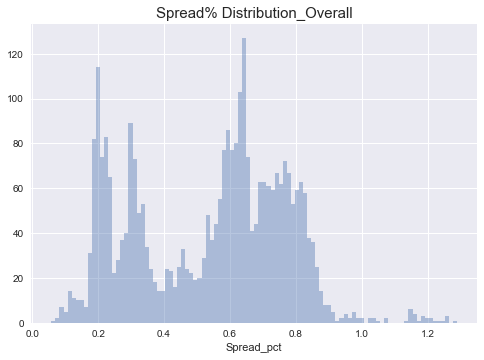

In [25]:
plt.title('Spread% Distribution_Overall', fontsize = 15)
sns.distplot(df_merged.Spread_pct,bins= 100,kde=False)

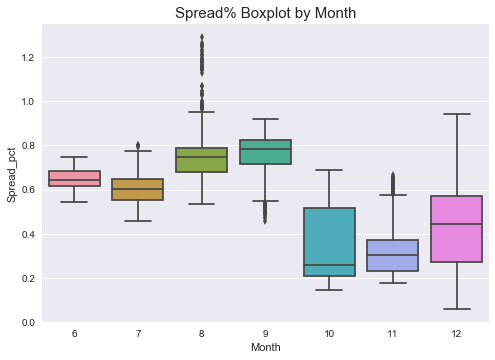

In [103]:
plt.title('Spread% Boxplot by Month', fontsize = 15)
sns.boxplot(x= 'Month', y='Spread_pct', data=df_merged)

Box plots indicate a constantly shifting mean, and widening standard deviation after September.  Lower means are observed for the period October-December

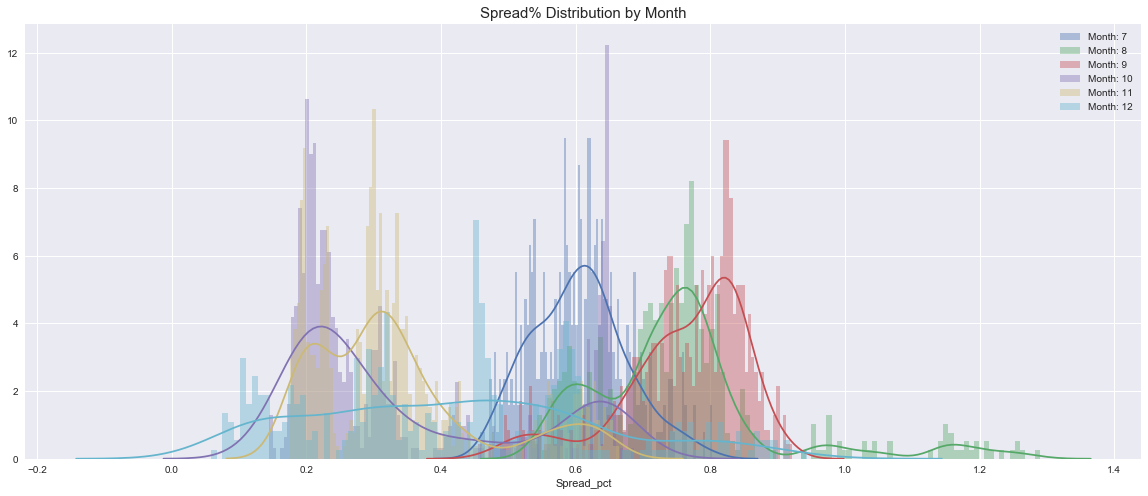

In [61]:
plt.figure(figsize=(20,8))
plt.title('Spread% Distribution by Month', fontsize = 15)

for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    sns.distplot(df_tmp.Spread_pct, bins = 100, label ='Month: '+str(m))
    plt.legend(loc=0)

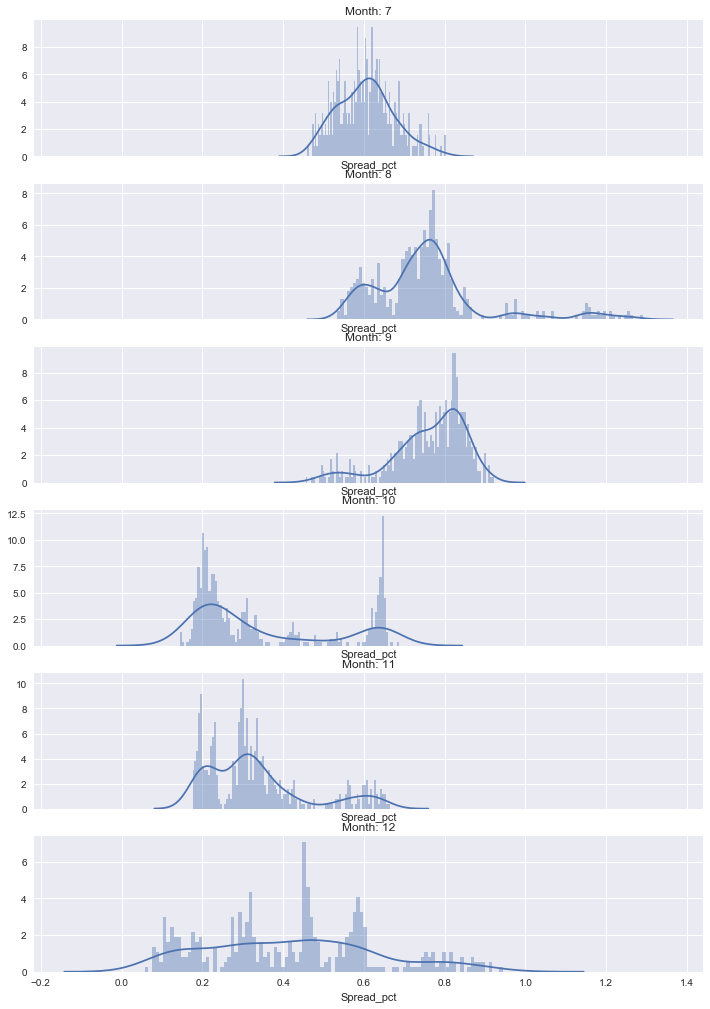

In [27]:
fig, ax = plt.subplots(6, 1, sharex=True, figsize = (12,17.5)) 
for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    sns.distplot(df_tmp.Spread_pct, bins = 100, label ='Month: '+str(m), ax=ax[m-7])
    ax[m-7].set_title('Month: '+str(m) , fontsize = 12)    

Each month displays a unique distribution pattern. Very hard to comprehend.

** By Session: **

Distributions look alike across three sessions, implying no material difference is explained by Session time.

Notably, market open has more volatility than midday, followed by close, which is a normal trading pattern in stocks markets. 

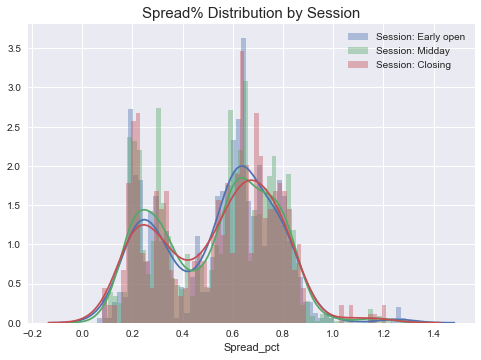

In [28]:
# plt.figure(figsize=(20,8))
plt.title('Spread% Distribution by Session', fontsize = 15)

sessions = ['Early open', 'Midday', 'Closing']
for s in sessions:
    df_tmp = df_merged[df_merged.Session == s]
    sns.distplot(df_tmp.Spread_pct, bins = 60, label ='Session: '+s)
    plt.legend(loc=0)

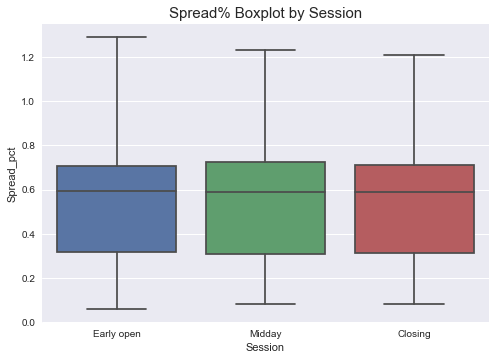

In [29]:
plt.title('Spread% Boxplot by Session', fontsize = 15)
sns.boxplot(x= 'Session', y='Spread_pct', data=df_merged)

**Now, Spread_chg%:**

While it looks a lot more normal, it's easy to see that it exhibits really small variances but big fat tails, especially on the downsied. What caught my attention is the jagged lines on both tails, which means large deviations from mean occur more often then smaller ones. 

Overall, it's a very interesting plot

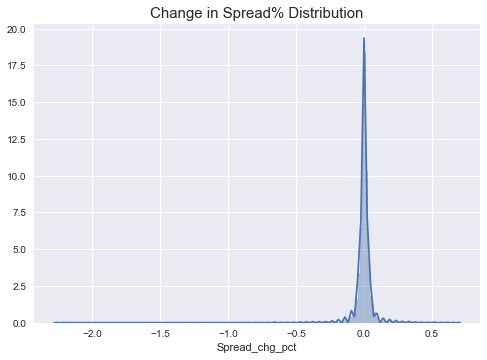

In [42]:
plt.title('Change in Spread% Distribution', fontsize = 15)
sns.distplot(df_merged.Spread_chg_pct,bins= 200,kde=True, norm_hist=True)

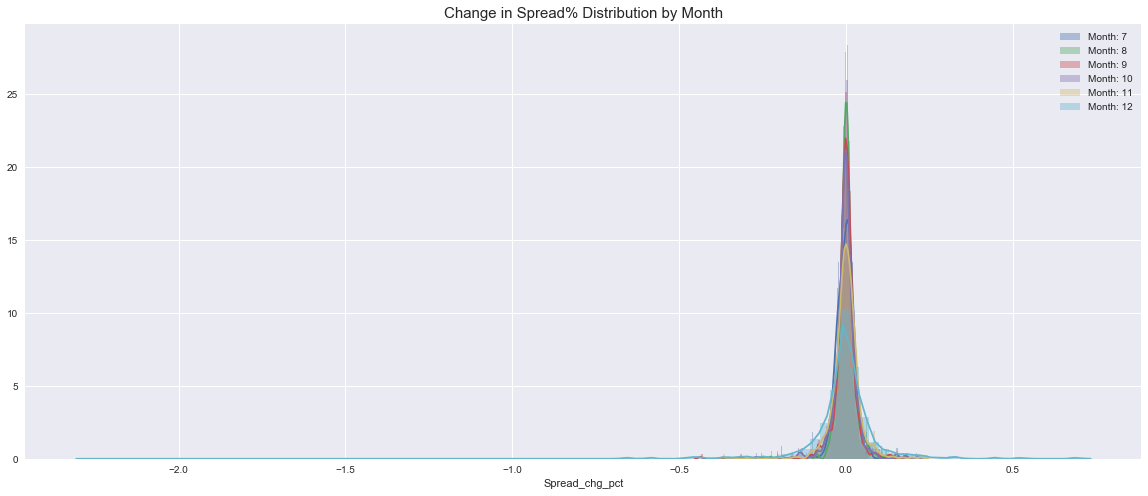

In [60]:
plt.figure(figsize=(20,8))
plt.title('Change in Spread% Distribution by Month', fontsize = 15)
# plt.xlim(-0.75, 0.75)
for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    sns.distplot(df_tmp.Spread_chg_pct, bins = 100, label ='Month: '+str(m))
    plt.legend(loc=0)

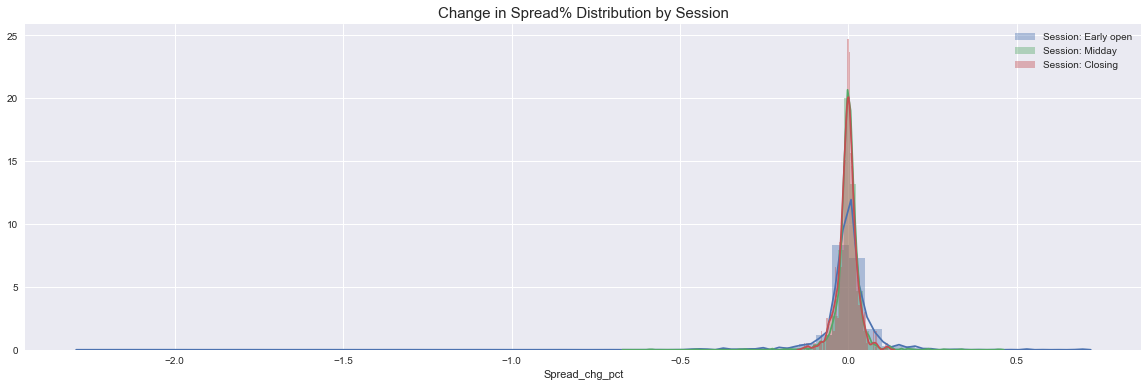

In [41]:
plt.figure(figsize=(20,6))
plt.title('Change in Spread% Distribution by Session', fontsize = 15)

sessions = ['Early open', 'Midday', 'Closing']
for s in sessions:
    df_tmp = df_merged[df_merged.Session == s]
    sns.distplot(df_tmp.Spread_chg_pct, bins = 60, label ='Session: '+s)
    plt.legend(loc=0)

**What about correlation? **

Scatter plot reveals no linear relationship between Change in Spread% and changes in NAV or volume. 

Correlation matrix also indicates a dynamic, ever-changing correlation between these guys. 

Arguably, there's no consistent causal relationship between Spread% change and variables such as Volume and NAV.

(-0.75, 0.75)

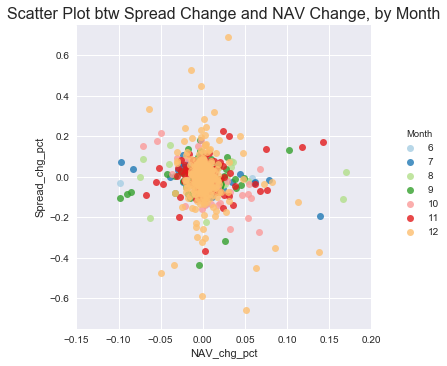

In [55]:
sns.lmplot('NAV_chg_pct', 'Spread_chg_pct', data=df_merged,hue='Month', fit_reg=False, palette='Paired')
plt.title('Scatter Plot btw Spread Change and NAV Change, by Month', fontsize = 16)
plt.xlim(-0.15,0.2)
plt.ylim(-0.75, 0.75)

(-0.75, 0.75)

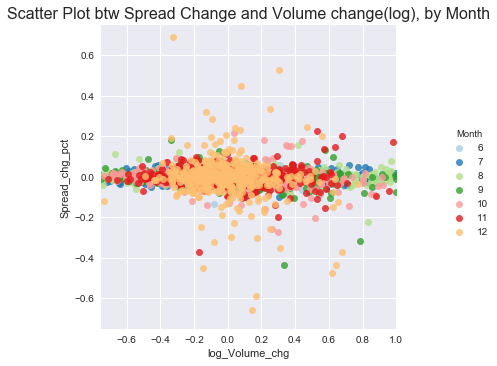

In [54]:
sns.lmplot('log_Volume_chg', 'Spread_chg_pct', data=df_merged,hue='Month', fit_reg=False, palette='Paired')
plt.title('Scatter Plot btw Spread Change and Volume change(log), by Month', fontsize = 16)
plt.xlim(-0.75,1.0)
plt.ylim(-0.75, 0.75)

(-0.75, 0.75)

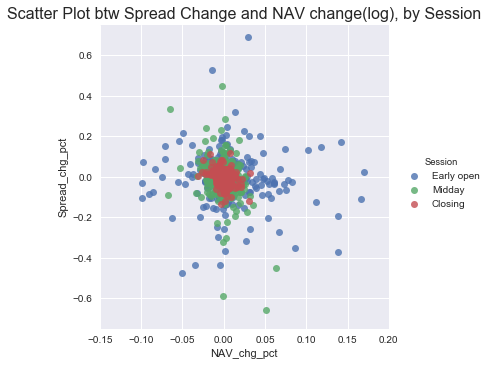

In [53]:
sns.lmplot('NAV_chg_pct', 'Spread_chg_pct', data=df_merged,hue='Session', fit_reg=False)
plt.title('Scatter Plot btw Spread Change and NAV change(log), by Session', fontsize = 16)
plt.xlim(-0.15,0.2)
plt.ylim(-0.75, 0.75)

Correlation is non-static: 


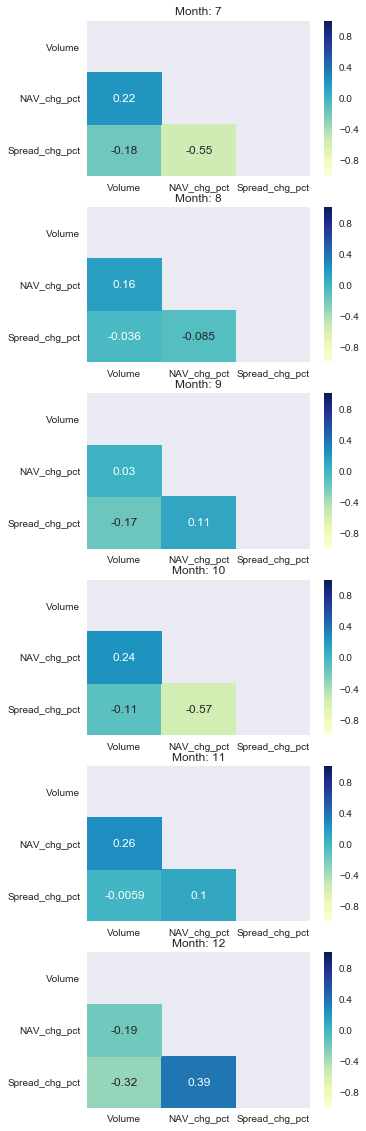

In [59]:
print('Correlation is non-static: ')
fig, ax = plt.subplots(6, 1, figsize = (5,20)) 

for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    df_tmp = df_tmp[['Volume','NAV_chg_pct', 'Spread_chg_pct']]
    matrix_temp = df_tmp.corr()
    mask = np.zeros_like(matrix_temp, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(matrix_temp,annot=True, mask=mask, ax=ax[m-7], cmap="YlGnBu")
    ax[m-7].set_title('Month: '+str(m) )    

Notes to myself..

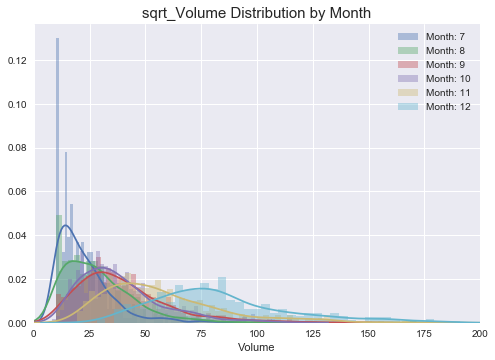

In [65]:

plt.xlim(0,200)
plt.title('sqrt_Volume Distribution by Month', fontsize = 15)

for m in range(7,13):
    df_tmp = df_merged[df_merged.Month == m]
    sns.distplot(np.sqrt(df_tmp.Volume), bins = 60, label ='Month: '+str(m))
    plt.legend(loc=0)

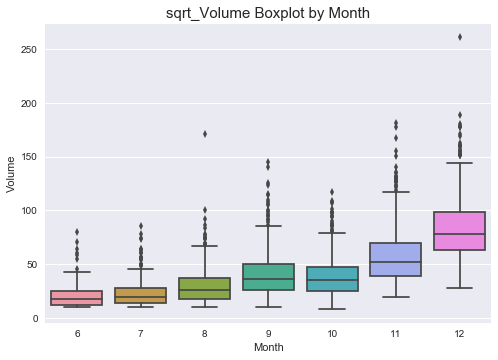

In [104]:
plt.title('sqrt_Volume Boxplot by Month', fontsize = 15)
sns.boxplot(x= 'Month', y=np.sqrt(df_merged.Volume), data=df_merged)

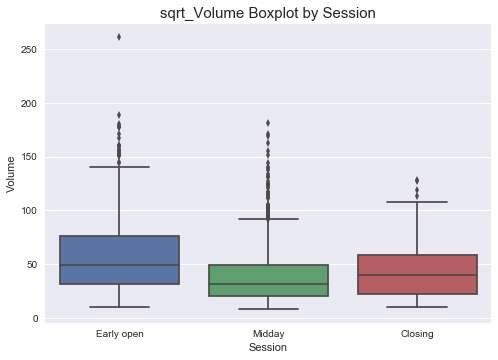

In [112]:
plt.title('sqrt_Volume Boxplot by Session', fontsize = 15)
sns.boxplot(x= 'Session', y=np.sqrt(df_merged.Volume), data=df_merged)

### Observations
> There's no material difference in Spread% among three sessions
> As is usually the case with equity markets. Volume is high at opening, followed by closing, then midday.
> What is interesting, however, is the distribution plots of Spread% exhibit bimodal distribution, i.e. two distinctive apex.

url: https://stackoverflow.com/questions/10529492/how-do-i-plot-only-weekdays-using-pythons-matplotlib-candlestick

plot the weekday x-axis

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode()
# import cufflinks as cf
# print(cf.__version__)
# cf.go_offline()

> url: https://www.reddit.com/r/IPython/comments/3tibc8/tip_on_how_to_run_plotly_examples_in_offline_mode/


trace_GBTC = Scatter(
                x=df_merged.Date_time,
                y=df_merged.Price_GBTC,
                name = "GBTC Intraday Price",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_NAV = Scatter(
                x=df_merged.Date_time,
                y=df_merged.Adj_NAV,
                name = "Adjusted NAV",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

data = [trace_GBTC,trace_NAV]

layout = dict(
    title = "Spread Chart of GBTC vs NAV",
    height = 600,
    width = 800,
    xaxis = dict(
        range = ['2017-06-21','2017-12-22'])
)

fig = dict(data=data, layout=layout)
iplot(fig,kind='spread')

